In [2]:
'''PACKAGE IMPORTS'''
#For data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy
import xarray as xr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
from itertools import cycle
from scipy.optimize import curve_fit

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

from math import log10, floor, pow, e, sqrt

from functions import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
'''Import Data Links'''
import_path = "./data/original-data/"
paper_savepath = "./figures/Paper/"

In [4]:
'''Colors'''
pal = sns.color_palette(["#ffffcc", "#c2e699", "#78c679", "#31a354", "#006837"], 5, as_cmap= True)
pal


['#ffffcc', '#c2e699', '#78c679', '#31a354', '#006837']

In [5]:
'''Functions'''
def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

## Import and Setup

In [6]:
'''Import Data'''
### Import Snow Data
s2data = xr.open_dataset(import_path + '01_cleanedsnowdataS2.nc')
s2data_df = s2data.to_dataframe().reset_index(drop = False)
s2data_df = s2data_df.replace('NaN', np.nan)
s2data_df = s2data_df.replace('nan', np.nan)
s2data_df.time = pd.to_datetime(s2data_df.time)
s2data_df['watershed'] = 'S2'

s6data = xr.open_dataset(import_path + '01_cleanedsnowdataS6.nc')
s6data_df = s6data.to_dataframe().reset_index(drop = False)
s6data_df = s6data_df.replace('NaN', np.nan)
s6data_df = s6data_df.replace('nan', np.nan)
s6data_df.time = pd.to_datetime(s6data_df.time)
s6data_df['watershed'] = 'S6'

allSnow_df = pd.concat([s6data_df, s2data_df]).reset_index()

### Import LAI Data
s2LAI = pd.read_csv(import_path + "S2_winterLAI_calibrated.csv")
s6LAI = pd.read_csv(import_path + "S6_winterLAI_calibrated.csv")
lai_df = pd.concat([s2LAI, s6LAI]).reset_index()

### Import forestry Data -- summarized by stake
forestInv = pd.read_csv(import_path + 'VegData_LAI_Snow.csv')

### Import Weekly Met Data
weeklyMet = pd.read_csv(import_path + "WeeklyATMSummary.csv")

# Import SWE data
SWE = pd.read_csv(import_path + "2023SWE_data.csv", 
                parse_dates = ['DATE'])

In [7]:
'''Add Snow Year'''
#Snow year
allSnow_df['SYear'] = [2024 if allSnow_df.time[i] > pd.to_datetime('09-01-2023') else 2023 for i in range(0, len(allSnow_df.time))]

#Date of snow year
allSnow_df['SDOY'] = [(allSnow_df.time[i] - pd.to_datetime('09-01-2023')).days if allSnow_df.SYear[i] == 2024 else (allSnow_df.time[i] - pd.to_datetime('09-01-2022')).days for i in range(0, len(allSnow_df.time))]
allSnow_df.head()

,index,northing,easting,time,stakes,zones,aspect,slope,depths,watershed,SYear,SDOY
0,0,464644.0,5262240.0,2022-11-25,NaN,NaN,NaN,NaN,NaN,S6,2023,85
1,1,464644.0,5262240.0,2022-12-02,NaN,NaN,NaN,NaN,NaN,S6,2023,92
2,2,464644.0,5262240.0,2022-12-30,NaN,NaN,NaN,NaN,NaN,S6,2023,120
3,3,464644.0,5262240.0,2023-01-05,NaN,NaN,NaN,NaN,NaN,S6,2023,126
4,4,464644.0,5262240.0,2023-01-13,NaN,NaN,NaN,NaN,NaN,S6,2023,134


In [8]:
#Retrofit one veg data outlier
#Stake S234 -- labelled all bog trees at dominant when they probably should have been codominant
forestInv.loc[18,  'Co'] = [20]
forestInv.loc[18,  'Dom'] = [0]
forestInv[forestInv.Stake_ID == 'S234']

,Stake_ID,X,Zone,X..Sky.Area,X..Mask.Area,X..Cnpy.Open,X..Site.Open,LAI.4Ring,LAI.5Ring,Watershed,...,Dom,Int,Sup,prop_Deciduous,prop_Coniferous,WATERSHED,OAItree,OAI,avg_depths,max_depths
18,S234,19,Bog,99.89,0.11,28.49,28.49,1.0725,1.195,S2,...,0,6,0,0.0,1.0,S2,7830.873516,7830.873516,39.6875,70.0


In [9]:
'''Organize all data into one data frame'''
#Remove rows on allSnow containing NaNs (these are grid locations where data was not taken)
allSnow_nan = allSnow_df.dropna(how = 'any')

#Take peak snow depth per site
peakSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed', 'SYear'])['depths'].max().reset_index()
peakSnow = peakSnow.rename(columns = {'depths' : 'maxDepth'})

#Take average snow depth per site
avgSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed', 'SYear'])['depths'].mean().reset_index()
avgSnow = avgSnow.rename(columns = {'depths' : 'meanDepth'})

#Add in other columns aggregated by year, joined on stakes
## LAI
lai_sub = lai_df[['Stake_ID', 'OLS Prediction Ring 5']]
peakData = pd.merge(peakSnow, lai_sub, left_on = 'stakes', right_on = 'Stake_ID')
peakData = peakData.drop(columns = 'Stake_ID')
peakData = peakData.rename(columns = {'OLS Prediction Ring 5' : 'lai5ring'})

avgData = pd.merge(avgSnow, lai_sub, left_on = 'stakes', right_on = 'Stake_ID')
avgData = avgData.drop(columns = 'Stake_ID')
avgData = avgData.rename(columns = {'OLS Prediction Ring 5' : 'lai5ring'})

## Veg Survey
veg_sub = forestInv[['Stake_ID', 'DIST_M', 'DBH_CM', 'DIST_M_SD', 'DBH_CM_SD', 'n', 'basalArea_m2', 'Co', 'Dom', 'Int', 'Sup', 'prop_Coniferous']]
peakData = pd.merge(peakData, veg_sub, left_on = 'stakes', right_on = 'Stake_ID')
peakData = peakData.drop(columns = 'Stake_ID')
peakData = peakData.rename(columns = {'DIST_M' : 'avgDist_m',
                                    'DBH_CM' : 'avgDBH_cm',
                                    'DIST_M_SD' : 'sdDist_m',
                                    'DBH_CM_SD' : 'sdDBH_cm',
                                    'n' : 'nTrees',
                                    'Co' : 'nCo',
                                    'Dom' : 'nDom',
                                    'Int' : 'nInt',
                                    'Sup' : 'nSup',
                                    'prop_Coniferous' : 'pCon'})

avgData = pd.merge(avgData, veg_sub, left_on = 'stakes', right_on = 'Stake_ID')
avgData = avgData.drop(columns = 'Stake_ID')
avgData = avgData.rename(columns = {'DIST_M' : 'avgDist_m',
                                    'DBH_CM' : 'avgDBH_cm',
                                    'DIST_M_SD' : 'sdDist_m',
                                    'DBH_CM_SD' : 'sdDBH_cm',
                                    'n' : 'nTrees',
                                    'Co' : 'nCo',
                                    'Dom' : 'nDom',
                                    'Int' : 'nInt',
                                    'Sup' : 'nSup',
                                    'prop_Coniferous' : 'pCon'})

In [10]:
#Save peak data
peakData.to_csv('./data/original-data/peak-snow-data.csv', index = False)

In [11]:
peakData.head()

,stakes,northing,easting,zones,aspect,slope,watershed,SYear,maxDepth,lai5ring,...,avgDBH_cm,sdDist_m,sdDBH_cm,nTrees,basalArea_m2,nCo,nDom,nInt,nSup,pCon
0,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2023,70.0,0.380709,...,20.983333,1.290040,7.624701,12,4.651855,7,2,3,0,0.000000
1,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2024,22.0,0.380709,...,20.983333,1.290040,7.624701,12,4.651855,7,2,3,0,0.000000
2,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2023,59.0,0.403804,...,24.216667,1.604152,11.569547,18,10.077594,9,3,6,0,0.111111
3,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2024,18.0,0.403804,...,24.216667,1.604152,11.569547,18,10.077594,9,3,6,0,0.111111
4,S203,464819.0,5262396.0,Upland,135.0012,7.452870,S2,2023,49.0,1.373774,...,14.543750,1.841889,3.984632,16,2.845013,11,3,2,0,0.437500


## Melt Data

In [12]:
'''Import Melt Data'''
melt = pd.read_csv(import_path + 'snowMeltRates.csv')
melt.head()

,stakes,northing,easting,zones,aspect,slope,watershed,MaxDate_mod,firstSnow_mod,lastSnow_mod,accumulate_mod,melt_mod,MaxDate_meas,firstSnow_meas,lastSnow_meas,accumulate_meas,melt_meas
0,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-24,2022-12-02 00:00:00,2024-02-15 00:00:00,112 days,328 days
1,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-24,2022-12-02 00:00:00,2024-02-15 00:00:00,112 days,328 days
2,S202,464819.0,5262344.0,Upland,352.4059,2.166370,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-17,2022-12-30 00:00:00,2024-02-15 00:00:00,77 days,335 days
3,S203,464819.0,5262396.0,Upland,135.0012,7.452870,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-31,2022-12-02 00:00:00,2024-02-15 00:00:00,119 days,321 days
4,S204,464819.0,5262448.0,Upland,254.4066,9.503919,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-17,2022-12-30 00:00:00,2024-02-15 00:00:00,77 days,335 days


In [13]:
#Merge Data with other descriptors for analysis
meltData = pd.merge(melt[['stakes', 'MaxDate_meas', 'firstSnow_meas', 'lastSnow_meas', 'accumulate_meas', 'melt_meas']],
                    peakData,
                    on = 'stakes')

In [14]:
#Remove 'days' text from columns
meltData['melt_meas'] = [int(a[0:-4]) for a in meltData.melt_meas]
meltData['accumulate_meas'] = [int(a[0:-4]) for a in meltData.accumulate_meas]

## General Snow Analysis

In [15]:
allSnow_df.head()

,index,northing,easting,time,stakes,zones,aspect,slope,depths,watershed,SYear,SDOY
0,0,464644.0,5262240.0,2022-11-25,NaN,NaN,NaN,NaN,NaN,S6,2023,85
1,1,464644.0,5262240.0,2022-12-02,NaN,NaN,NaN,NaN,NaN,S6,2023,92
2,2,464644.0,5262240.0,2022-12-30,NaN,NaN,NaN,NaN,NaN,S6,2023,120
3,3,464644.0,5262240.0,2023-01-05,NaN,NaN,NaN,NaN,NaN,S6,2023,126
4,4,464644.0,5262240.0,2023-01-13,NaN,NaN,NaN,NaN,NaN,S6,2023,134


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
Passing `palette` without assigning `hue` is deprecated.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


Text(0, 0.5, ' ')

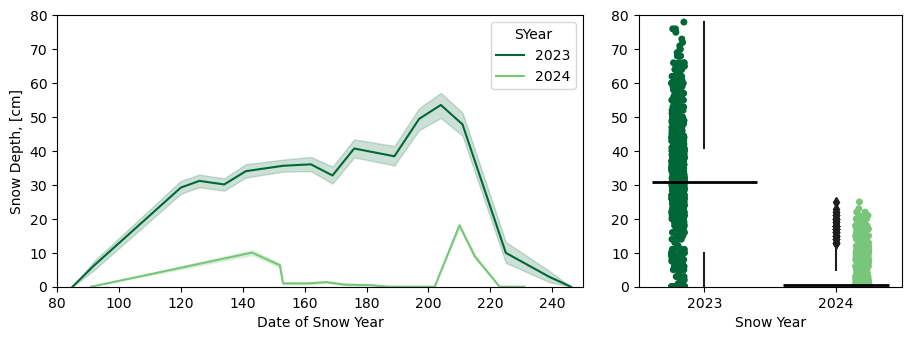

In [16]:
###Plot winter snow timeseries
fig = plt.figure(constrained_layout = True, 
    figsize = (9,6))

gs = GridSpec(2, 3, figure = fig)

ax = fig.add_subplot(gs[0, 0:2])
sns.lineplot(x = allSnow_df.SDOY, y = allSnow_df.depths, hue = allSnow_df.SYear, 
            palette = [pal[4], pal[2]], ax = ax)
ax.set_xlim(80, 250)
ax.set_ylim(0, 80)
ax.set_xlabel('Date of Snow Year')
ax.set_ylabel('Snow Depth, [cm]')

ax2 = fig.add_subplot(gs[0, 2])
sns.boxplot(data = allSnow_df, x = 'SYear', y = 'depths',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            palette = [pal[4], pal[2]],
            ax = ax2, zorder = 1)
sns.stripplot(data = allSnow_df, x = 'SYear', y = 'depths', dodge = True, 
              palette = [pal[4], pal[2]],
              ax = ax2, zorder = 0)
ax2.set_ylim(0, 80)
ax2.set_xlabel('Snow Year')
ax2.set_ylabel(' ')

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

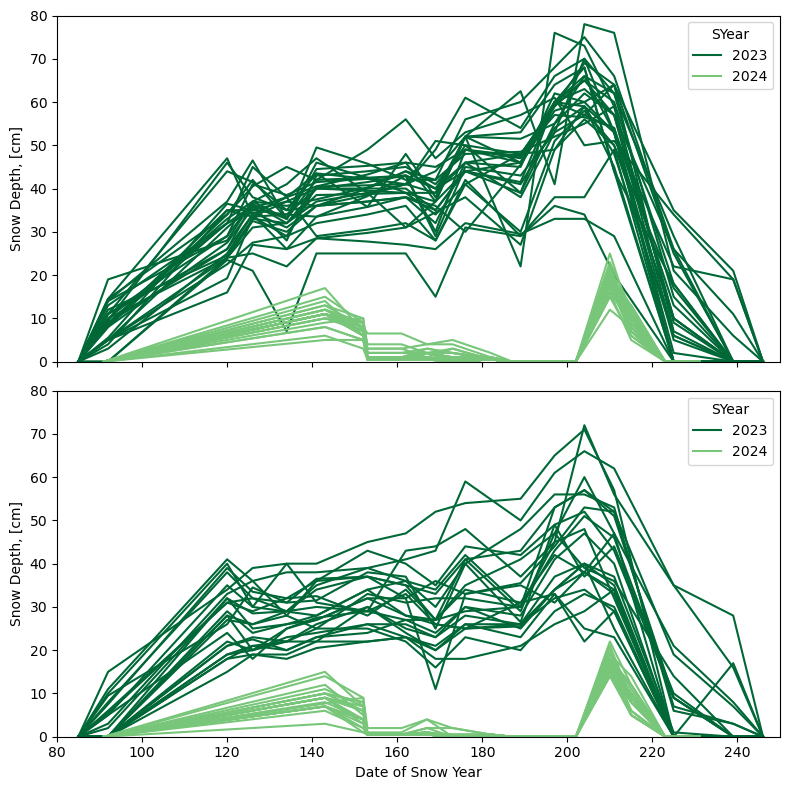

In [17]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (8, 8), 
                               sharex = True, 
                               sharey = True, 
                               layout = 'tight')

sns.lineplot(data = allSnow_df[allSnow_df.watershed == 'S2'], x = 'SDOY', y = 'depths', hue = 'SYear',
            units = 'stakes',
            estimator = None, 
            palette = [pal[4], pal[2]],
            ax = ax1)
ax1.set_xlim(80, 250)
ax1.set_ylim(0, 80)
ax1.set_ylabel('Snow Depth, [cm]')

sns.lineplot(data = allSnow_df[allSnow_df.watershed == 'S6'], x = 'SDOY', y = 'depths', hue = 'SYear',
            units = 'stakes',
            estimator = None, 
            palette = [pal[4], pal[2]],
            ax = ax2)
ax2.set_ylabel('Snow Depth, [cm]')
ax2.set_xlabel('Date of Snow Year')
plt.savefig('./figures/WaterSciCon/snowdepths.pdf')

## LAI Analysis

(0.008631149028106, 2.67733068332974)

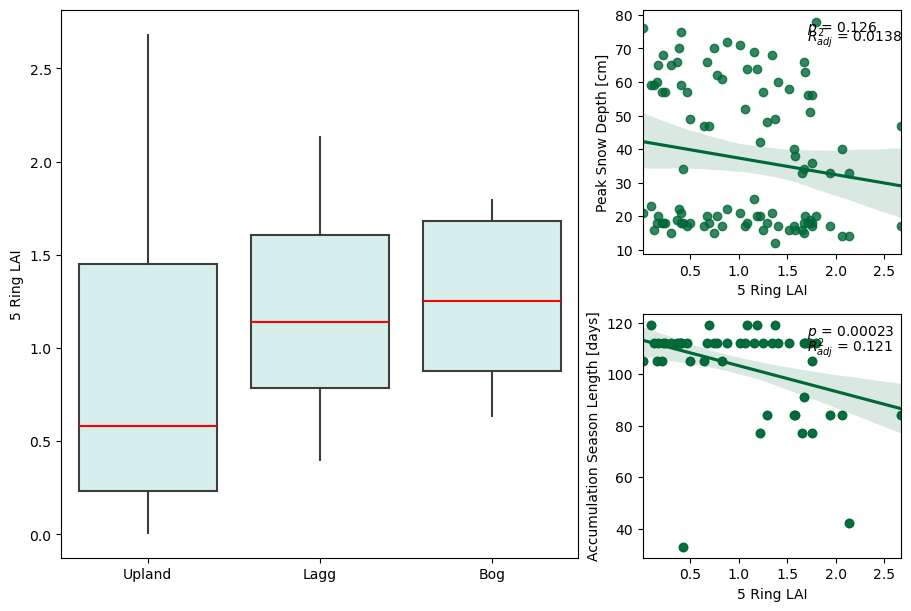

In [18]:
fig = plt.figure(layout = "constrained", figsize = (9, 6))

gs = GridSpec(2, 3, figure = fig)
ax = fig.add_subplot(gs[0:2, 0:2])
sns.boxplot(data = peakData, x = 'zones', y = 'lai5ring',
    notch=False, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": [0.4795847750865052, 0.7984621299500193, 0.7695501730103806, 0.3]},
    medianprops={"color": "red"},
    ax = ax)
ax.set_xlabel(' ')
ax.set_ylabel('5 Ring LAI')

ax2 = fig.add_subplot(gs[0, 2])
sns.regplot(data = peakData, x = 'lai5ring', y = 'maxDepth', color = pal[4])
results = smf.ols('maxDepth ~ lai5ring', data = peakData).fit()
ax2.text(1.7, 75, r'$ p $ = ' + str(round_sig(results.pvalues.lai5ring, 3)))
ax2.text(1.7, 72, r'$ R_{adj}^2 $ = ' + str(round_sig(results.rsquared_adj, 3)))

ax2.set_xlabel('5 Ring LAI')
ax2.set_ylabel('Peak Snow Depth [cm]')
ax2.set_xlim(min(peakData.lai5ring), max(peakData.lai5ring))

ax3 = fig.add_subplot(gs[1, 2])
sns.regplot(data = meltData, x = 'lai5ring', y = 'accumulate_meas', color = pal[4])
results2 = smf.ols('accumulate_meas ~ lai5ring', data = meltData).fit()
ax3.text(1.7, 115, r'$ p $ = ' + str(round_sig(results2.pvalues.lai5ring, 3)))
ax3.text(1.7, 109, r'$ R_{adj}^2 $ = ' + str(round_sig(results2.rsquared_adj, 3)))

ax3.set_xlabel('5 Ring LAI')
ax3.set_ylabel('Accumulation Season Length [days]')
ax3.set_xlim(min(meltData.lai5ring), max(meltData.lai5ring))

#plt.savefig(paper_savepath + 'laicorplot_boxplot.pdf', bbox_inches = 'tight')



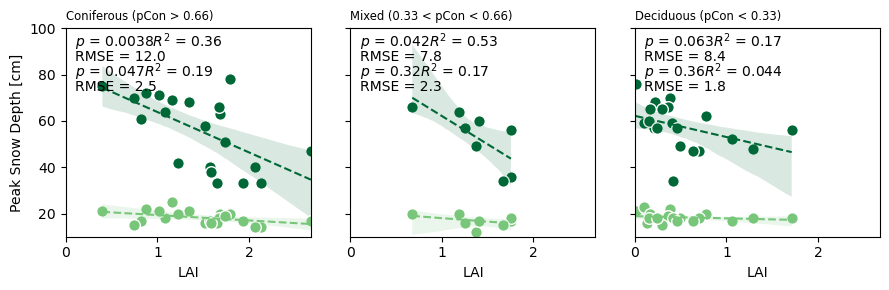

In [19]:
#Prep Data
bins = list(np.linspace(np.nanmin(peakData.pCon), np.nanmax(peakData.pCon), 4))
labels = ['Dense Deciduous', 'Mixed', 'Dense Coniferous']
peakData['Bin'] = pd.cut(peakData['pCon'], include_lowest = True, bins = bins, labels = labels)

#Plotting function
def plotLAICovertype(data, ax, color, xlab, ylab):
    sns.regplot(data = data, x = 'lai5ring', y = 'maxDepth', 
                ax = ax, 
                color = color, 
                label = 'High Snow', 
                scatter_kws = {'s' : 70, 'edgecolor' : "white", 'alpha' : 1}, 
                line_kws = {'linestyle' : '--', 'linewidth' : 1.5})
    mod = smf.ols('maxDepth ~ lai5ring', data = data).fit()
    ax.text(xlab, ylab, r'$ p $ = ' + str(round_sig(mod.pvalues.lai5ring, 2)) + r'$ R^2 $ = ' + str(round_sig(mod.rsquared, 2)))
    ax.text(xlab, ylab - 6, 'RMSE = ' + str(round_sig(sqrt(np.sum((mod.resid)**2)/(len(mod.resid))), 2)))

#Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')


plotLAICovertype(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2023)], ax1, pal[4], 0.1, 92)
plotLAICovertype(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2024)], ax1, pal[2], 0.1, 79)
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('LAI')

plotLAICovertype(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2023)], ax2, pal[4], 0.1, 92)
plotLAICovertype(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2024)], ax2, pal[2], 0.1, 79)
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('LAI')

plotLAICovertype(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2023)], ax3, pal[4], 0.1, 92)
plotLAICovertype(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2024)], ax3, pal[2], 0.1, 79)
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('LAI')

ax1.set_xlim(0, max(peakData.lai5ring))
ax1.set_ylim(10, 100)

plt.savefig(paper_savepath + 'covertype_lairegression.pdf', bbox_inches = 'tight')

In [20]:
peakData.Bin.value_counts()

Bin
Dense Deciduous     42
Dense Coniferous    42
Mixed               16
Name: count, dtype: int64

## Principle Component Analysis

In [21]:
'''Set PCA Data'''
#Switch this depending on average/maximum snow depth considerations
pca_data = peakData

#remove strings
pca_data_forplot = pca_data.drop(columns = ['stakes', 'zones', 'watershed', 'Bin'])

#remove depths 
pca_data = pca_data_forplot.drop(columns = 'maxDepth')

In [22]:
'''Principle Component Analysis to Determine Snow Controls'''
#Standardize Data
scaler = StandardScaler()
scaler.fit(pca_data)
pca_data_scaled = scaler.transform(pca_data)
#Convert back to dataframe
pca_scaled = pd.DataFrame(data = pca_data_scaled, 
                            columns = pca_data.columns)


In [23]:
pca_scaled.head()

,northing,easting,aspect,slope,SYear,lai5ring,avgDist_m,avgDBH_cm,sdDist_m,sdDBH_cm,nTrees,basalArea_m2,nCo,nDom,nInt,nSup,pCon
0,1.849643,-1.201287,0.147365,0.326056,-1.0,-1.005747,0.460653,0.462296,-1.632968,0.247573,-0.595224,-0.223636,-0.619642,0.436436,-0.132527,-0.573105,-1.380173
1,1.849643,-1.201287,0.147365,0.326056,1.0,-1.005747,0.460653,0.462296,-1.632968,0.247573,-0.595224,-0.223636,-0.619642,0.436436,-0.132527,-0.573105,-1.380173
2,1.849643,-1.020997,-0.635011,-0.273271,-1.0,-0.970471,-1.198747,1.225059,-0.789059,1.338819,0.161417,1.741685,-0.286501,1.118367,0.814095,-0.573105,-1.082135
3,1.849643,-1.020997,-0.635011,-0.273271,1.0,-0.970471,-1.198747,1.225059,-0.789059,1.338819,0.161417,1.741685,-0.286501,1.118367,0.814095,-0.573105,-1.082135
4,1.849643,-0.660417,-0.436038,0.466111,-1.0,0.511104,-0.164034,-1.056841,-0.150345,-0.759363,-0.090797,-0.878113,0.046640,1.118367,-0.448068,-0.573105,-0.206649


In [24]:
#Run PCA
pca = PCA(n_components = 10) #adjustable
pca.fit_transform(pca_data_scaled)

#Extract variance values
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

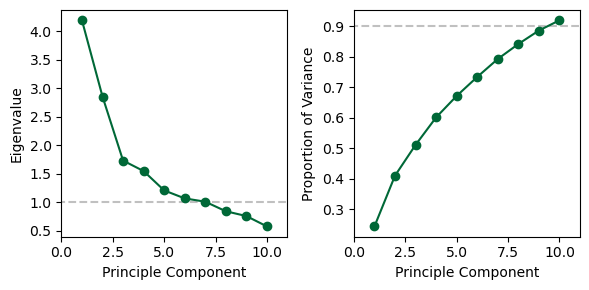

In [25]:
#Scree Plot
PCnumbers = np.arange(pca.n_components_) + 1

fig, [ax, ax2] = plt.subplots(1, 2, figsize = (6, 3), 
                              sharex = True, 
                              tight_layout = True)

ax.plot(PCnumbers, 
         eigenvalues, 
         'o-',
         color = pal[4])
ax.hlines(1, xmax = 0, xmin = 12, colors = 'silver', linestyles = '--', zorder = -1)
ax.set_ylabel('Eigenvalue')
ax.set_xlabel('Principle Component')

ax2.plot(PCnumbers, 
         np.cumsum(prop_var), 
         'o-', 
         color = pal[4])
ax2.hlines(0.90, xmax = 0, xmin = 12, colors = 'silver', linestyles = '--', zorder = -1)

ax2.set_ylabel('Proportion of Variance')
ax2.set_xlabel('Principle Component')

ax.set_xlim(0, 11)
#plt.savefig(fig_savepath + 'PCAeigenvalues.pdf', bbox_inches = 'tight')
plt.show()
#Using Kaiser's rule we keep all principle components with eigenvalues above 1 and rerun (here 5)

In [26]:
#Rerun PCA
pca2 = PCA(n_components = 5) #adjustable
pc = pca2.fit_transform(pca_data_scaled)

pca_snow = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pca_snow.head()

,PC1,PC2,PC3,PC4,PC5
0,2.218373,0.546700,1.761302,1.001182,0.435904
1,2.218373,0.546700,1.761302,1.001182,0.435904
2,1.706302,1.987550,0.840318,1.240829,-0.914231
3,1.706302,1.987550,0.840318,1.240829,-0.914231
4,0.517243,-1.535036,0.884199,0.212008,-0.342734



The palette list has fewer values (5) than needed (42) and will cycle, which may produce an uninterpretable plot.

The palette list has fewer values (5) than needed (42) and will cycle, which may produce an uninterpretable plot.

The palette list has fewer values (5) than needed (42) and will cycle, which may produce an uninterpretable plot.

The palette list has fewer values (5) than needed (42) and will cycle, which may produce an uninterpretable plot.
Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


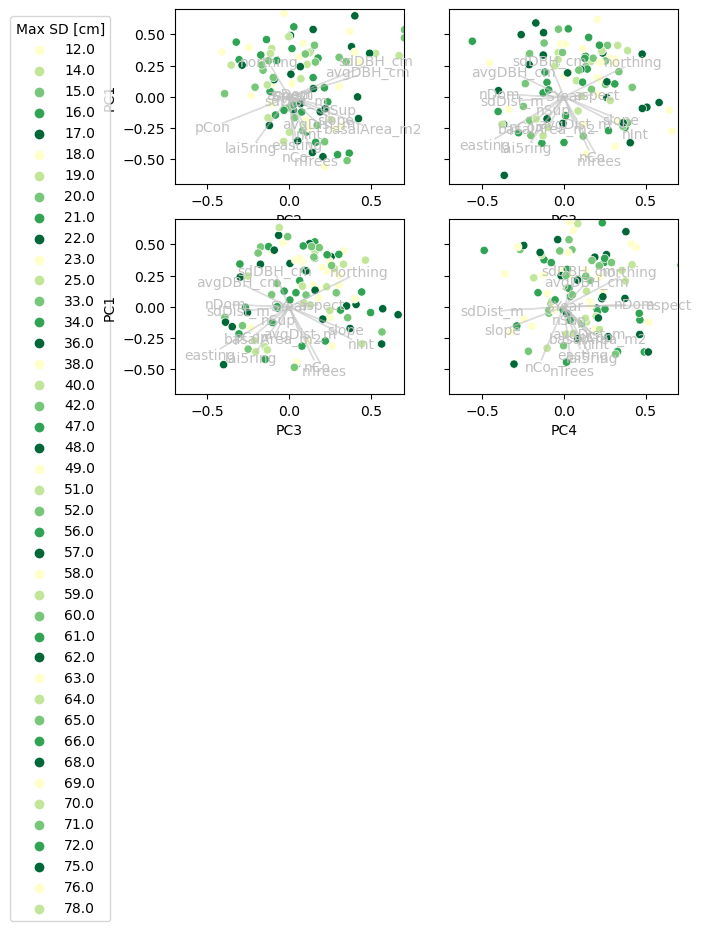

In [27]:
'''BiPlot'''
def biplot(ax, data, score, coef, ipca1, ipca2, labels=None, leg=None):
 
    xs = score[:, ipca1]
    ys = score[:, ipca2]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    sns.scatterplot(x = jitter(xs * scalex, 0.1), y = jitter(ys * scaley, 0.1), 
                hue = data.maxDepth, 
                ax = ax,
                palette = pal,
                legend = leg)
 
    for i in range(n):
        ax.arrow(0, 0, coef[i, ipca1], 
                  coef[i, ipca2], color = 'silver',
                  alpha = 0.5)
        ax.text(coef[i, ipca1]* 1.15, 
                 coef[i, ipca2] * 1.15, 
                 labels[i], 
                 color = 'silver', 
                 ha = 'center', 
                 va = 'center')
 
    ax.set_xlabel("PC{}".format(ipca1 + 1))
    ax.set_ylabel("PC{}".format(ipca2 + 1)) 

    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)

    #plt.title('Biplot of PCA')   

    #plt.show()

 
fig, axs = plt.subplots(2, 2, figsize = (6.5,5), 
                        tight_layout = True, 
                        sharey = True)
for i in range(0, 2):
    for j in range(0, 2):
        if((i == 0) & (j == 0)):
            biplot(axs[i, j], pca_data_forplot, pc, np.transpose(pca.components_), i+j+1, 0, list(pca_data.columns), True)
        else:
            biplot(axs[i, j], pca_data_forplot, pc, np.transpose(pca.components_), i+j+1, 0, list(pca_data.columns))

axs[0, 0].legend(title = 'Max SD [cm]', bbox_to_anchor = (-0.25, 1))
#plt.savefig(fig_savepath + 'PCAplots.pdf', bbox_inches = 'tight')
plt.show()

### Variable Importance Analysis

In [28]:
#Sort out PCA coefficients
pca_coefs = pd.DataFrame(data = abs(np.transpose(pca2.components_)), columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index = pca_data.columns)
pca_coefs.head()

,PC1,PC2,PC3,PC4,PC5
northing,2.379483e-01,1.079752e-01,3.701706e-01,3.412884e-01,1.314183e-01
easting,3.342421e-01,4.106242e-02,4.189738e-01,1.002823e-01,3.113330e-02
aspect,1.358355e-02,5.925288e-04,1.734076e-01,5.540343e-01,2.987041e-01
slope,1.632400e-01,2.470470e-01,3.032834e-01,3.267011e-01,3.433491e-02
SYear,8.383139e-18,1.486060e-16,2.967024e-17,9.996492e-17,5.512903e-16


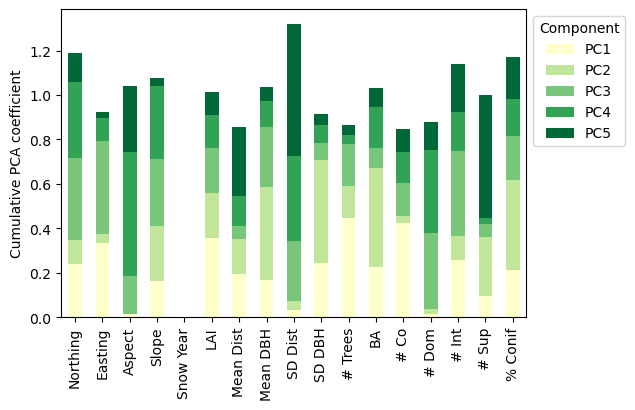

In [29]:
#Variable Importance Plots
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

pca_coefs.plot(kind = 'bar', stacked = True, ax = ax, color = pal)

ax.set_xticklabels(['Northing', 'Easting', 'Aspect', 'Slope', 'Snow Year', 'LAI', 'Mean Dist', 'Mean DBH', 'SD Dist', 'SD DBH', '# Trees', 'BA', '# Co', '# Dom', '# Int', '# Sup', '% Conif'])
ax.legend(title = 'Component', bbox_to_anchor = (1,1))
ax.set_ylabel('Cumulative PCA coefficient')
#plt.savefig(fig_savepath + 'PCAcoef.pdf', bbox_inches = 'tight')
plt.show()

In [30]:
#Version weighted by PCA explained percentage
pca_coefs_weighted = pca_coefs
for i in range(0, 5):
    pca_coefs_weighted.iloc[:, i] = pca_coefs_weighted.iloc[:, i]*prop_var[i]

pca_coefs_weighted.head()

,PC1,PC2,PC3,PC4,PC5
northing,5.813980e-02,1.796343e-02,3.734504e-02,3.077182e-02,9.249007e-03
easting,8.166802e-02,6.831402e-03,4.226860e-02,9.041825e-03,2.191111e-03
aspect,3.318976e-03,9.857682e-05,1.749441e-02,4.995378e-02,2.102231e-02
slope,3.988572e-02,4.110030e-02,3.059705e-02,2.945658e-02,2.416435e-03
SYear,2.048319e-18,2.472302e-17,2.993313e-18,9.013207e-18,3.879891e-17


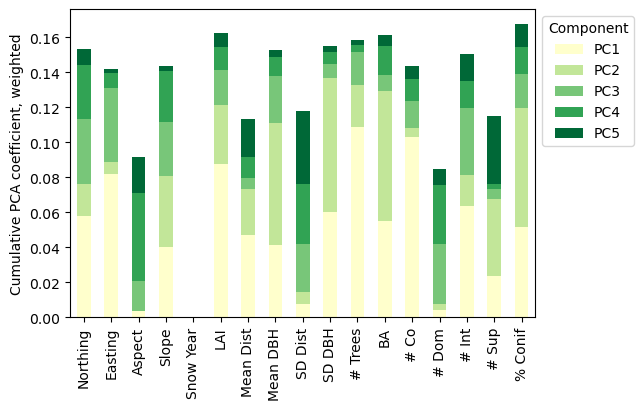

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

pca_coefs_weighted.plot(kind = 'bar', stacked = True, ax = ax, color = pal)

ax.set_xticklabels(['Northing', 'Easting', 'Aspect', 'Slope', 'Snow Year', 'LAI', 'Mean Dist', 'Mean DBH', 'SD Dist', 'SD DBH', '# Trees', 'BA', '# Co', '# Dom', '# Int', '# Sup', '% Conif'])
ax.legend(title = 'Component', bbox_to_anchor = (1,1))
ax.set_ylabel('Cumulative PCA coefficient, weighted')
#plt.savefig(fig_savepath + 'PCAcoef-weighted.pdf', bbox_inches = 'tight')
plt.show()

## Random Forest Variable Importance

In [32]:
def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



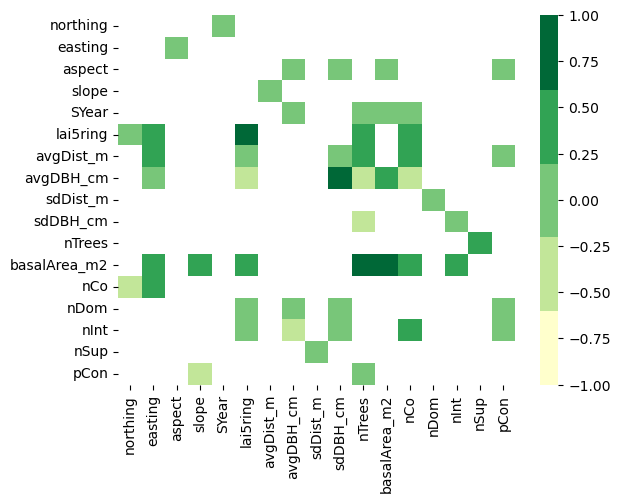

In [33]:
#Variable intercorrelation
pvals = calculate_pvalues(pca_data) 
sigvals = np.where(pvals < 0.05, pvals, np.nan)

sns.heatmap(pca_data.corr(),
                xticklabels=pca_data.columns,
                yticklabels=pca_data.columns, 
            cmap = pal, 
            mask = sigvals, 
            center = 0, 
            vmin = -1, vmax = 1)

plt.savefig(paper_savepath + 'correlation_heatmap.pdf', bbox_inches = 'tight')

### Variable Importance for Peak Snow Depth

In [34]:
#Split data
X_train_2023, X_test_2023, y_train_2023, y_test_2023 = train_test_split(pca_data[pca_data.SYear == 2023],
                                                                        pca_data_forplot[pca_data_forplot.SYear == 2023].maxDepth,
                                                                        test_size = 0.5, random_state = 48492)
X_train_2024, X_test_2024, y_train_2024, y_test_2024 = train_test_split(pca_data[pca_data.SYear == 2024],
                                                                        pca_data_forplot[pca_data_forplot.SYear == 2024].maxDepth,
                                                                        test_size = 0.5, random_state = 48492)

#Fit random forest regression with 100 trees
rf2023 = RandomForestRegressor(n_estimators = 100)
rf2023.fit(X_train_2023, y_train_2023)
rf2024 = RandomForestRegressor(n_estimators = 100)
rf2024.fit(X_train_2024, y_train_2024)

RandomForestRegressor()

In [35]:
#Model assessment
preds2023 = rf2023.predict(X_test_2023)
preds2024 = rf2024.predict(X_test_2024)

#Score
print('2023 High Snow Model\n')
print(rf2023.score(X_train_2023, y_train_2023))
print(rf2023.score(X_test_2023, y_test_2023))

print('\n2024 Low Snow Model\n')
print(rf2024.score(X_train_2024, y_train_2024))
print(rf2024.score(X_test_2024, y_test_2024))

#Overfitting problem

2023 High Snow Model

0.8929791928041337
0.3052846996508969

2024 Low Snow Model

0.8753608182730923
-0.19211439393939367


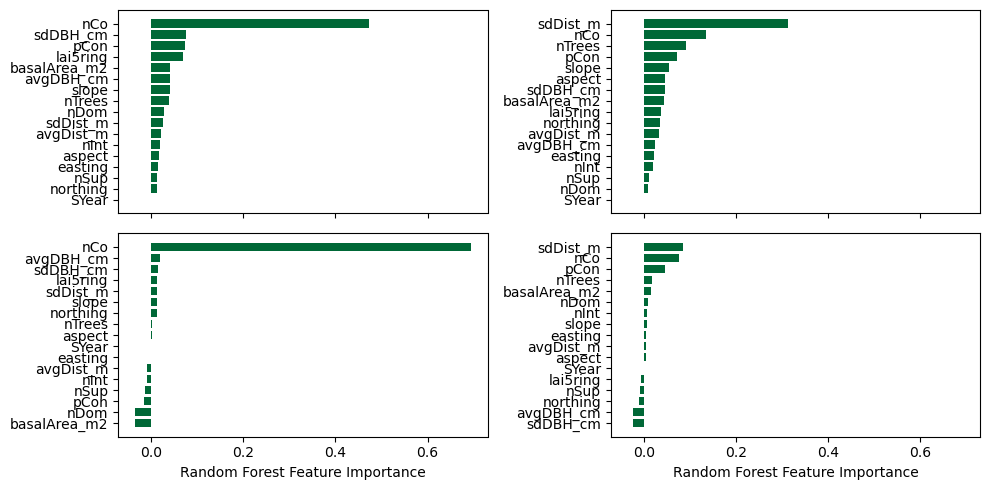

In [36]:
#Sort and plot feature importance
sorted_idx2023 = rf2023.feature_importances_.argsort()
sorted_idx2024 = rf2024.feature_importances_.argsort()

fig,[[ax, ax3],[ax2, ax4]] = plt.subplots(2, 2, figsize = (10, 5), 
                              sharex = True, 
                              tight_layout = True)

#2023
#Without permutation
ax.barh(pca_data.columns[sorted_idx2023], rf2023.feature_importances_[sorted_idx2023], 
        color = pal[4])
#ax.set_yticklabels(['Aspect', 'Northing', '# Sup', '# Int', 'Mean Dist', '# Trees', 'Easting', 'Slope', 'Mean DBH', '# Dom', 'LAI', 'BA', '% Con', '# Co'])

#With permutation
perm_importance2023 = permutation_importance(rf2023, X_test_2023, y_test_2023)

sorted_idx2023 = perm_importance2023.importances_mean.argsort()
ax2.barh(pca_data[pca_data.SYear == 2023].columns[sorted_idx2023], perm_importance2023.importances_mean[sorted_idx2023], 
         color = pal[4])
#ax2.set_yticklabels(['# Dom', '# Sup', '# Int', 'Easting', 'Aspect', 'Mean Dist', 'BA', '# Trees', 'Slope', 'Northing', 'Mean DBH', 'LAI', '% Con', '# Co'])

#2024
#Without permutation
ax3.barh(pca_data.columns[sorted_idx2024], rf2024.feature_importances_[sorted_idx2024], 
        color = pal[4])
#ax.set_yticklabels(['Aspect', 'Northing', '# Sup', '# Int', 'Mean Dist', '# Trees', 'Easting', 'Slope', 'Mean DBH', '# Dom', 'LAI', 'BA', '% Con', '# Co'])

#With permutation
perm_importance2024 = permutation_importance(rf2024, X_test_2024, y_test_2024)

sorted_idx2024 = perm_importance2024.importances_mean.argsort()
ax4.barh(pca_data[pca_data.SYear == 2024].columns[sorted_idx2024], perm_importance2024.importances_mean[sorted_idx2024], 
         color = pal[4])
#ax2.set_yticklabels(['# Dom', '# Sup', '# Int', 'Easting', 'Aspect', 'Mean Dist', 'BA', '# Trees', 'Slope', 'Northing', 'Mean DBH', 'LAI', '% Con', '# Co'])


ax2.set_xlabel("Random Forest Feature Importance")
ax4.set_xlabel("Random Forest Feature Importance")


#plt.savefig(fig_savepath + 'randomForest-importance.pdf', bbox_inches = 'tight')
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


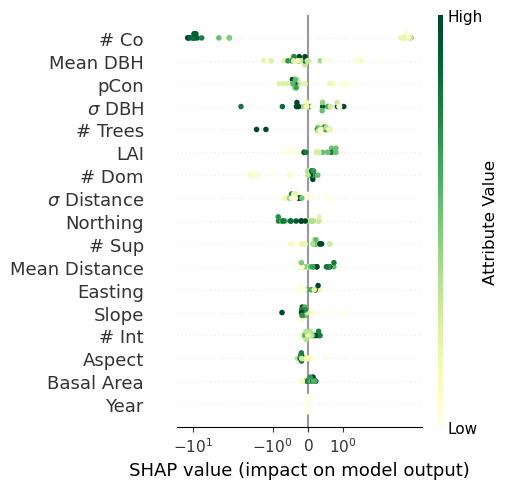

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


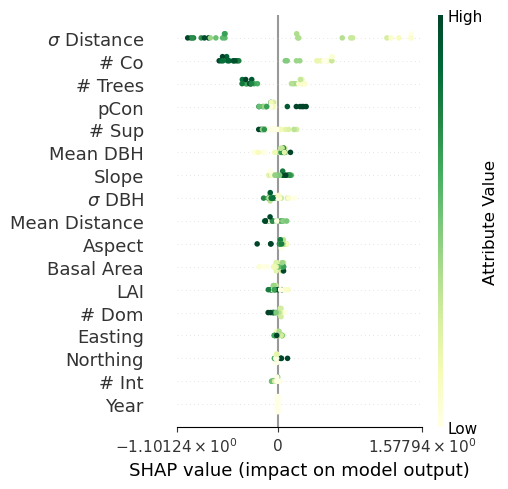

In [37]:
#SHAP values
explainer2023 = shap.TreeExplainer(rf2023)
shap_values2023 = explainer2023.shap_values(X_test_2023)
explainer2024 = shap.TreeExplainer(rf2024)
shap_values2024 = explainer2024.shap_values(X_test_2024)


fig, ax = plt.subplots(1, 1)
shap.summary_plot(shap_values2023, X_test_2023,
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
#ax.set_yticklabels(['# Co', 'Mean DBH', 'pCon', r'/sigma DBH', '# Trees', 'LAI', '# Dom', r'\sigma Distance', 'Northing', '# Sup', 'Mean Distance', 'Easting', 'Slope', '# Int', 'Aspect', 'Basal Area', 'Year'])
ax.set_yticklabels(['Year', 'Basal Area', 'Aspect', '# Int', 'Slope', 'Easting', 'Mean Distance', '# Sup', 'Northing', r'$\sigma$ Distance', '# Dom', 'LAI', '# Trees', r'$\sigma$ DBH', 'pCon', 'Mean DBH', '# Co'])
plt.savefig('./figures/WaterSciCon/randomForest-SHAP-highsnow.pdf', bbox_inches = 'tight')
plt.savefig('./figures/WaterSciCon/randomForest-SHAP-highsnow.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()


fig, ax = plt.subplots(1, 1)
shap.summary_plot(shap_values2024, X_test_2024,
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
#ax.set_yticklabels([r'$\sigma$ Distance', '# Co', '# Trees', 'pCon', '# Sup', 'Mean DBH', 'Slope', r'$\sigma$ DBH', 'Mean Distance', 'Aspect', 'Basal Area', 'LAI', '# Dom', 'Easting', 'Northing', '# Int', 'Year'])
ax.set_yticklabels(['Year', '# Int', 'Northing', 'Easting', '# Dom', 'LAI', 'Basal Area', 'Aspect', 'Mean Distance', r'$\sigma$ DBH', 'Slope', 'Mean DBH', '# Sup', 'pCon', '# Trees', '# Co', r'$\sigma$ Distance' ])
plt.savefig('./figures/WaterSciCon/randomForest-SHAP-lowsnow.pdf', bbox_inches = 'tight')
plt.savefig('./figures/WaterSciCon/randomForest-SHAP-lowsnow.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()

### Variable Importance Using Reduced Dimensions

In [38]:
pca_data_reduced = pca_data.drop(columns = ['northing', 'easting', 'SYear', 'nTrees', 'basalArea_m2', 'nInt', 'nSup', 'nDom'])

In [39]:
#Split data
X_train_reduced_2023, X_test_reduced_2023, y_train_reduced_2023, y_test_reduced_2023 = train_test_split(pca_data_reduced[pca_data.SYear == 2023],
                                                                        pca_data_forplot[pca_data_forplot.SYear == 2023].maxDepth,
                                                                        test_size = 0.2, random_state = 48492)
X_train_reduced_2024, X_test_reduced_2024, y_train_reduced_2024, y_test_reduced_2024 = train_test_split(pca_data_reduced[pca_data.SYear == 2024],
                                                                        pca_data_forplot[pca_data_forplot.SYear == 2024].maxDepth,
                                                                        test_size = 0.2, random_state = 48492)

#Fit random forest regression with 100 trees
rf2023_red = RandomForestRegressor(n_estimators = 100, max_depth = 5)
rf2023_red.fit(X_train_reduced_2023, y_train_reduced_2023)
rf2024_red = RandomForestRegressor(n_estimators = 100, max_depth = 5)
rf2024_red.fit(X_train_reduced_2024, y_train_reduced_2024)

RandomForestRegressor(max_depth=5)

In [40]:
#Model assessment
preds2023_red = rf2023_red.predict(X_test_reduced_2023)
preds2024_red = rf2024_red.predict(X_test_reduced_2024)

y2023 = y_test_reduced_2023
print('2023 Snow Year ')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y2023, preds2023_red))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y2023, preds2023_red))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y2023, preds2023_red)))
mape = np.mean(np.abs((y2023 - preds2023_red) / np.abs(y2023)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf2023_red.score(X_train_reduced_2023, y_train_reduced_2023))
print('Testing Score:', rf2023_red.score(X_test_reduced_2023, y_test_reduced_2023))
print('Accuracy:', round(100*(1 - mape), 2))

y2024 = y_test_reduced_2024
print('\n2024 Snow Year ')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y2024, preds2024_red))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y2024, preds2024_red))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y2024, preds2024_red)))
mape = np.mean(np.abs((y2024 - preds2024_red) / np.abs(y2024)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf2024_red.score(X_train_reduced_2024, y_train_reduced_2024))
print('Testing Score:', rf2024_red.score(X_test_reduced_2024, y_test_reduced_2024))
print('Accuracy:', round(100*(1 - mape), 2))

2023 Snow Year 
Mean Absolute Error (MAE): 7.433944713946185
Mean Squared Error (MSE): 87.4035721416124
Root Mean Squared Error (RMSE): 9.348987760266477
Mean Absolute Percentage Error (MAPE): 15.91
Training Score: 0.9355905681699818
Testing Score: 0.49422156043277354
Accuracy: 84.09

2024 Snow Year 
Mean Absolute Error (MAE): 1.929633925143484
Mean Squared Error (MSE): 4.665667680357571
Root Mean Squared Error (RMSE): 2.1600156666926216
Mean Absolute Percentage Error (MAPE): 11.13
Training Score: 0.8207975309689861
Testing Score: -0.2644085854627565
Accuracy: 88.87


#### ML Model Tuning

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

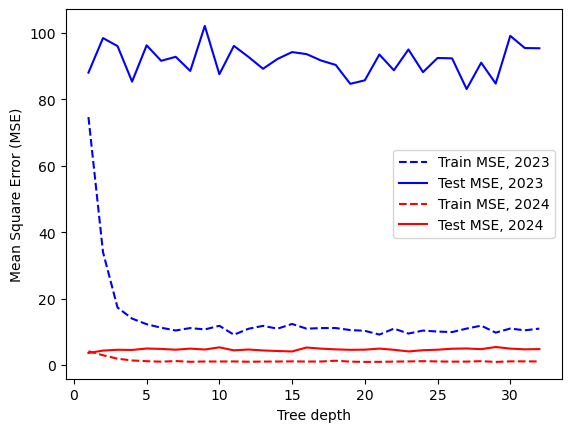

In [41]:
#Test different model hyperparameters
max_depths = np.linspace(1, 32, 32, endpoint=True, dtype = 'int')

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for max_depth in max_depths:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = 100, max_depth = max_depth, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = 100, max_depth = max_depth, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = max_depths, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = max_depths, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = max_depths, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = max_depths, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Tree depth')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

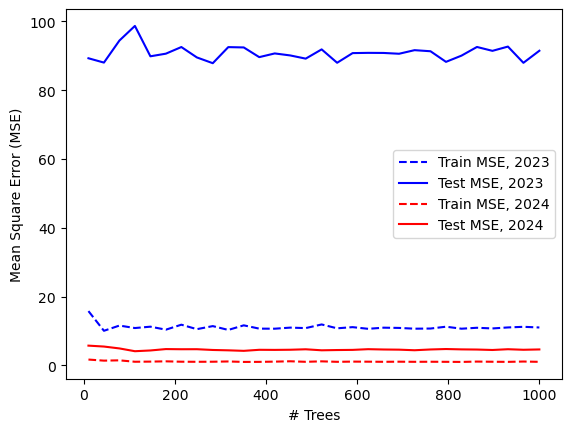

In [42]:
#Test different model hyperparameters
n_trees = np.linspace(10, 1000, 30, endpoint=True, dtype = 'int')

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for tree in n_trees:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = tree, max_depth = 5, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = tree, max_depth = 5, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = n_trees, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = n_trees, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = n_trees, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = n_trees, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('# Trees')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

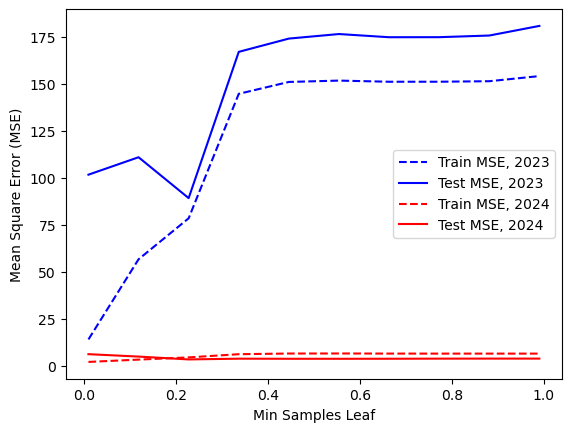

In [43]:
#Test different model hyperparameters
min_samples_leafs = np.linspace(0.01, 0.99, 10, endpoint=True)

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for leaf in min_samples_leafs:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = leaf, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = leaf, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = min_samples_leafs, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = min_samples_leafs, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = min_samples_leafs, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = min_samples_leafs, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Min Samples Leaf')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

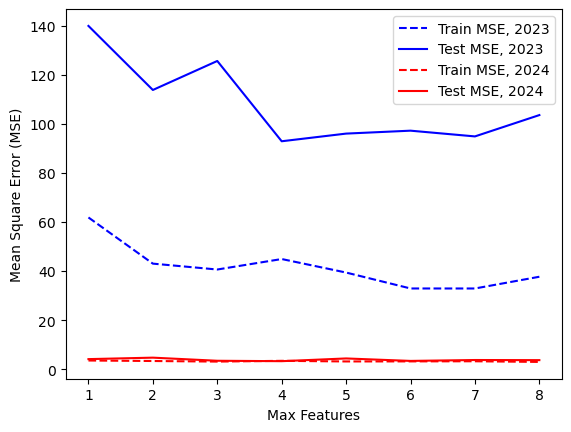

In [44]:
#Test different model hyperparameters
max_features = list(range(1,X_train_reduced_2023.shape[1]))

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for feature in max_features:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = 0.1, max_features = feature, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = 0.1, max_features = feature, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = max_features, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = max_features, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = max_features, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = max_features, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Max Features')
plt.show()

#### All data - Snow Year Dummy Variable

In [45]:
pca_data_reduced_all = pca_data.drop(columns = ['northing', 'easting', 'nTrees', 'basalArea_m2', 'nInt', 'nSup', 'nDom'])

In [46]:
#Split data
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(pca_data_reduced_all,
                                                                        pca_data_forplot.maxDepth,
                                                                        test_size = 0.2, random_state = 48492)

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


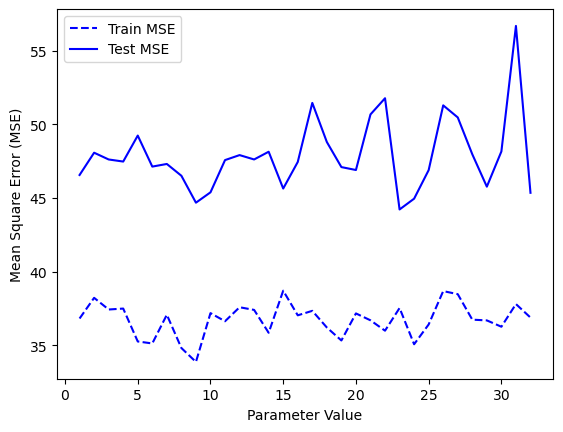

In [47]:
#Test different model hyperparameters
params = np.linspace(1, 32, 32, endpoint=True, dtype = 'int') #tree depths
#params = np.linspace(10, 1000, 30, endpoint=True, dtype = 'int') #n trees
#params = np.linspace(0.01, 0.99, 10, endpoint=True) #min leafs
#params  = list(range(1,X_train_reduced.shape[1])) # max features

train_results = []
test_results = []

for param in params:
   #Fit models
   rf = RandomForestRegressor(n_estimators = 100, max_depth = 3, min_samples_leaf = 0.1, max_features = 9, n_jobs = -1)
   rf.fit(X_train_reduced, y_train_reduced)

   #Predict data
   train_pred = rf.predict(X_train_reduced)
   y_pred = rf.predict(X_test_reduced)

   #Calculate MSE
   train_results.append(metrics.mean_squared_error(y_train_reduced, train_pred))
   test_results.append(metrics.mean_squared_error(y_test_reduced, y_pred))


sns.lineplot(x = params, y = train_results, color = 'blue', linestyle = '--', label = 'Train MSE')
sns.lineplot(x = params, y = test_results, color = 'blue', label = 'Test MSE')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Parameter Value')
plt.show()

In [48]:
#Fit random forest regression with tuned hyperparameters
rf_red = RandomForestRegressor(n_estimators = 100, max_depth = 3, min_samples_leaf = 0.1, max_features = 9)
rf_red.fit(X_train_reduced, y_train_reduced)

RandomForestRegressor(max_depth=3, max_features=9, min_samples_leaf=0.1)

In [49]:
preds_red = rf_red.predict(X_test_reduced)

y = y_test_reduced
print('All Snow Years')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y, preds_red))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y, preds_red))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y, preds_red)))
mape = np.mean(np.abs((y - preds_red) / np.abs(y)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf_red.score(X_train_reduced, y_train_reduced))
print('Testing Score:', rf_red.score(X_test_reduced, y_test_reduced))
print('Accuracy:', round(100*(1 - mape), 2))

All Snow Years
Mean Absolute Error (MAE): 5.108955412386367
Mean Squared Error (MSE): 47.26532413131635
Root Mean Squared Error (RMSE): 6.874978118606368
Mean Absolute Percentage Error (MAPE): 12.72
Training Score: 0.9133056563227153
Testing Score: 0.9063978847209356
Accuracy: 87.28


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


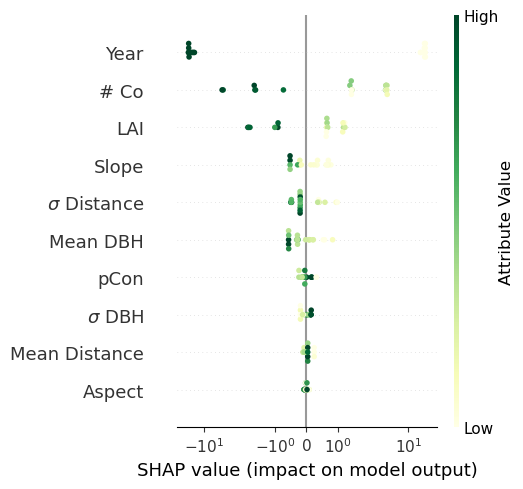

In [50]:
#SHAP values
explainer_red = shap.TreeExplainer(rf_red)
shap_values_red = explainer_red.shap_values(X_test_reduced)


fig, ax = plt.subplots(1, 1)
shap.summary_plot(shap_values_red, X_test_reduced,
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
ax.set_yticklabels(['Aspect', 'Mean Distance', r'$\sigma$ DBH', 'pCon', 'Mean DBH', r'$\sigma$ Distance', 'Slope','LAI', '# Co', 'Year'])
plt.savefig(paper_savepath + 'full_shapanalysis.pdf', bbox_inches = 'tight')
plt.show()


In [51]:
#Pull out row shap data for each snow year
s2023_ids = np.where(X_test_reduced.SYear == 2023)
sv2023 = shap_values_red[s2023_ids]

s2024_ids = np.where(X_test_reduced.SYear == 2024)
sv2024 = shap_values_red[s2024_ids]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


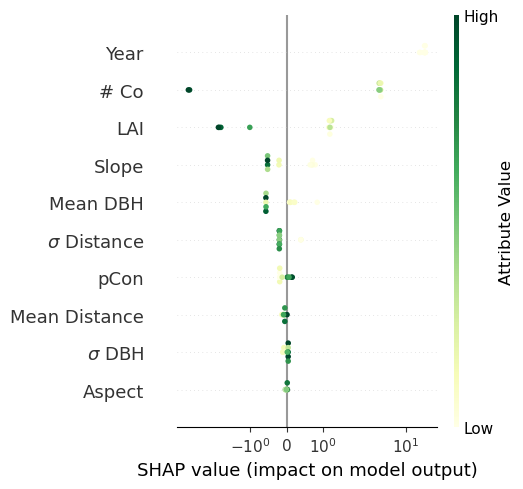

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


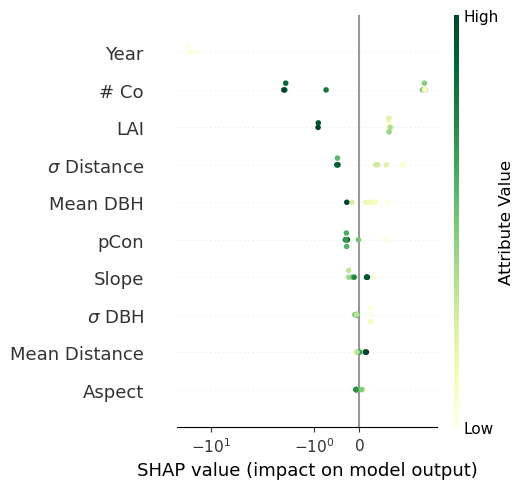

In [52]:
fig, ax = plt.subplots(1, 1)
shap.summary_plot(sv2023, X_test_reduced[X_test_reduced.SYear == 2023],
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
ax.set_yticklabels(['Aspect', r'$\sigma$ DBH', 'Mean Distance', 'pCon', r'$\sigma$ Distance', 'Mean DBH', 'Slope','LAI', '# Co', 'Year'])
plt.savefig(paper_savepath + '2023_shapanalysis.pdf', bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(1, 1)
shap.summary_plot(sv2024, X_test_reduced[X_test_reduced.SYear == 2024],
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
ax.set_yticklabels(['Aspect', 'Mean Distance', r'$\sigma$ DBH', 'Slope', 'pCon', 'Mean DBH', r'$\sigma$ Distance', 'LAI', '# Co', 'Year'])
plt.savefig(paper_savepath + '2024_shapanalysis.pdf', bbox_inches = 'tight')
plt.show()

In [53]:
#Also try dividing by cover type
conif_ids = np.where(X_test_reduced.pCon > bins[2])
svConif = shap_values_red[conif_ids]

mixed_ids = np.where((X_test_reduced.pCon > bins[1]) & (X_test_reduced.pCon < bins[2]))
svMixed = shap_values_red[mixed_ids]


decid_ids = np.where((X_test_reduced.pCon < bins[1]))
svDecid = shap_values_red[decid_ids]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


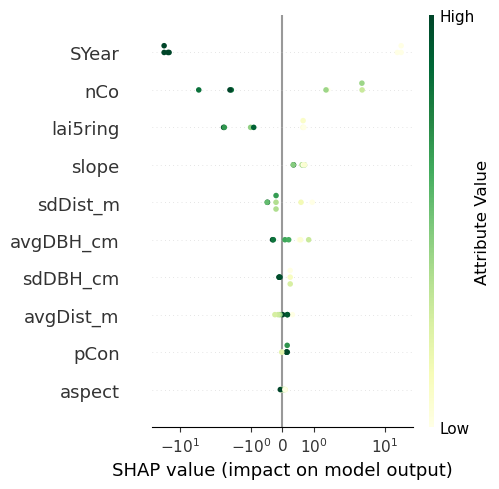

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


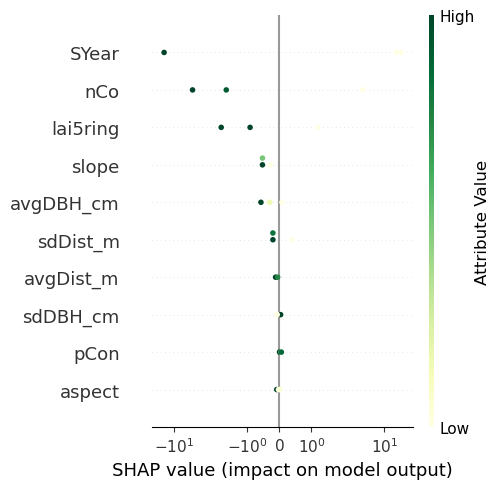

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


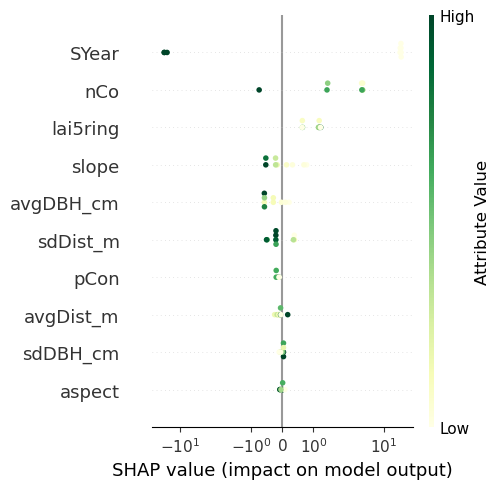

In [54]:
fig, ax = plt.subplots(1, 1)
shap.summary_plot(svConif, X_test_reduced[X_test_reduced.pCon > bins[2]],
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
plt.show()

fig, ax = plt.subplots(1, 1)
shap.summary_plot(svMixed, X_test_reduced[(X_test_reduced.pCon > bins[1]) & (X_test_reduced.pCon < bins[2])],
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
plt.show()

fig, ax = plt.subplots(1, 1)
shap.summary_plot(svDecid, X_test_reduced[(X_test_reduced.pCon < bins[1])],
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
plt.show()

### Repeat Analysis for Snow Melt Rates

In [55]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(pca_data_reduced_all, meltData.melt_meas, test_size = 0.2, random_state = 48492)

#Fit random forest regression with 100 trees
rf_melt = RandomForestRegressor(n_estimators = 100, max_depth = 4, max_features = 9)
rf_melt.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, max_features=9)

In [56]:
preds_melt = rf_melt.predict(X_test)

y = y_test
print('All Snow Years')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y, preds_melt))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y, preds_melt))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y, preds_melt)))
mape = np.mean(np.abs((y - preds_melt) / np.abs(y)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf_melt.score(X_train, y_train))
print('Testing Score:', rf_melt.score(X_test, y_test))
print('Accuracy:', round(100*(1 - mape), 2))

All Snow Years
Mean Absolute Error (MAE): 2.4345070659093153
Mean Squared Error (MSE): 15.768190554461594
Root Mean Squared Error (RMSE): 3.9709180996920086
Mean Absolute Percentage Error (MAPE): 0.71
Training Score: 0.9163332927033965
Testing Score: 0.8118129782257836
Accuracy: 99.29


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


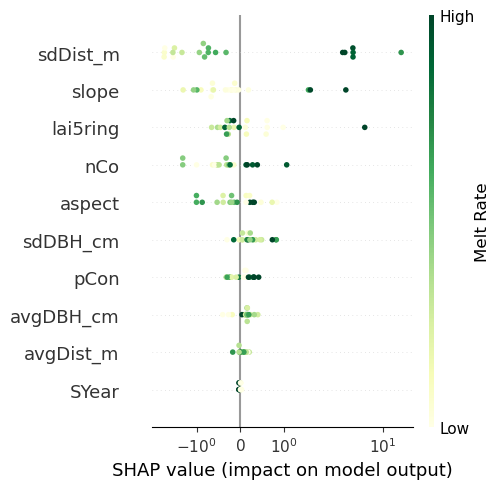

In [57]:
#SHAP values
explainer = shap.TreeExplainer(rf_melt)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test,
                cmap = 'YlGn', 
                plot_size = (5, 5), 
                color_bar_label = 'Melt Rate', 
                use_log_scale = True, 
                show = False)

#plt.savefig(fig_savepath + 'randomForest-SHAP-melt.pdf', bbox_inches = 'tight')

## Diversity Analysis

In [58]:
peakData.columns

Index(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope',
       'watershed', 'SYear', 'maxDepth', 'lai5ring', 'avgDist_m', 'avgDBH_cm',
       'sdDist_m', 'sdDBH_cm', 'nTrees', 'basalArea_m2', 'nCo', 'nDom', 'nInt',
       'nSup', 'pCon', 'Bin'],
      dtype='object')

In [59]:
#Compute Hill-Simpson Diversity Metric
def calcS(co, dom, int, sup):
    tot = np.sum(co + dom + int + sup)

    #calc proportions
    pCo = co/tot
    pDom = dom/tot
    pInt = int/tot
    pSup = sup/tot

    #calc index masking any zeroes
    S = np.sum(pow(pCo, 2) + pow(pDom, 2) + pow(pInt, 2) + pow(pSup, 2))

    return 1/S

peakData['S'] = [calcS(peakData.nCo[i], peakData.nDom[i], peakData.nInt[i], peakData.nSup[i]) for i in peakData.index]

(0.0, 100.0)

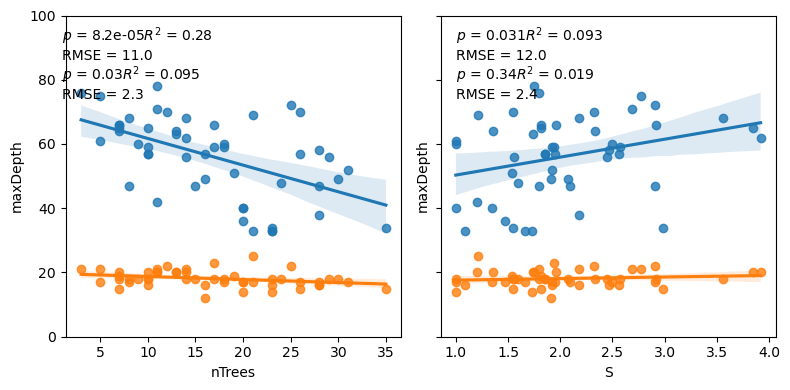

In [60]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (8, 4), 
                            sharey = True, 
                            layout = 'tight')

ntrees2023 = smf.ols('maxDepth ~ nTrees', data = peakData[peakData.SYear == 2023]).fit()
ntrees2024 = smf.ols('maxDepth ~ nTrees', data = peakData[peakData.SYear == 2024]).fit()
sns.regplot(data = peakData[peakData.SYear == 2023], x = 'nTrees', y = 'maxDepth', 
            ax = ax1)
sns.regplot(data = peakData[peakData.SYear == 2024], x = 'nTrees', y = 'maxDepth', 
            ax = ax1)
ax1.text(1, 92, r'$ p $ = ' + str(round_sig(ntrees2023.pvalues.nTrees, 2)) + r'$ R^2 $ = ' + str(round_sig(ntrees2023.rsquared, 2)))
ax1.text(1, 86, 'RMSE = ' + str(round_sig(sqrt(np.sum((ntrees2023.resid)**2)/(len(ntrees2023.resid))), 2)))
ax1.text(1, 80, r'$ p $ = ' + str(round_sig(ntrees2024.pvalues.nTrees, 2)) + r'$ R^2 $ = ' + str(round_sig(ntrees2024.rsquared, 2)))
ax1.text(1, 74, 'RMSE = ' + str(round_sig(sqrt(np.sum((ntrees2024.resid)**2)/(len(ntrees2024.resid))), 2)))

s2023 = smf.ols('maxDepth ~ S', data = peakData[peakData.SYear == 2023]).fit()
s2024 = smf.ols('maxDepth ~ S', data = peakData[peakData.SYear == 2024]).fit()
sns.regplot(data = peakData[peakData.SYear == 2023], x = 'S', y = 'maxDepth', 
            ax = ax2)
sns.regplot(data = peakData[peakData.SYear == 2024], x = 'S', y = 'maxDepth', 
            ax = ax2)
ax2.text(1, 92, r'$ p $ = ' + str(round_sig(s2023.pvalues.S, 2)) + r'$ R^2 $ = ' + str(round_sig(s2023.rsquared, 2)))
ax2.text(1, 86, 'RMSE = ' + str(round_sig(sqrt(np.sum((s2023.resid)**2)/(len(s2023.resid))), 2)))
ax2.text(1, 80, r'$ p $ = ' + str(round_sig(s2024.pvalues.S, 2)) + r'$ R^2 $ = ' + str(round_sig(s2024.rsquared, 2)))
ax2.text(1, 74, 'RMSE = ' + str(round_sig(sqrt(np.sum((s2024.resid)**2)/(len(s2024.resid))), 2)))

ax1.set_ylim(0,100)

In [72]:
peakData['log10divIndex'] = peakData.S/(np.log10(peakData.nTrees))
peakData.columns

Index(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope',
       'watershed', 'SYear', 'maxDepth', 'lai5ring', 'avgDist_m', 'avgDBH_cm',
       'sdDist_m', 'sdDBH_cm', 'nTrees', 'basalArea_m2', 'nCo', 'nDom', 'nInt',
       'nSup', 'pCon', 'Bin', 'S', 'logdivIndex', 'divIndex', 'sqrtdivIndex',
       'log10divIndex'],
      dtype='object')

(10.0, 100.0)

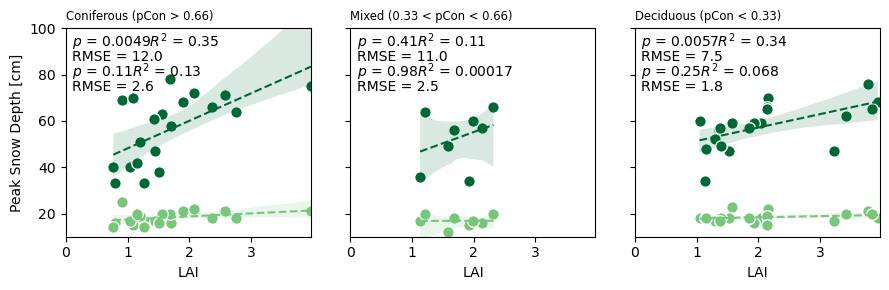

In [73]:
#Prep Data
bins = list(np.linspace(np.nanmin(peakData.pCon), np.nanmax(peakData.pCon), 4))
labels = ['Dense Deciduous', 'Mixed', 'Dense Coniferous']
peakData['Bin'] = pd.cut(peakData['pCon'], include_lowest = True, bins = bins, labels = labels)

#Plotting function
def plotaTreeCovertype(data, ax, color, xlab, ylab):
    sns.regplot(data = data, x = 'log10divIndex', y = 'maxDepth', 
                ax = ax, 
                color = color, 
                label = 'High Snow', 
                scatter_kws = {'s' : 70, 'edgecolor' : "white", 'alpha' : 1}, 
                line_kws = {'linestyle' : '--', 'linewidth' : 1.5})
    mod = smf.ols('maxDepth ~ log10divIndex', data = data).fit()
    ax.text(xlab, ylab, r'$ p $ = ' + str(round_sig(mod.pvalues.log10divIndex, 2)) + r'$ R^2 $ = ' + str(round_sig(mod.rsquared, 2)))
    ax.text(xlab, ylab - 6, 'RMSE = ' + str(round_sig(sqrt(np.sum((mod.resid)**2)/(len(mod.resid))), 2)))

#Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')


plotaTreeCovertype(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2023)], ax1, pal[4], 0.1, 92)
plotaTreeCovertype(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2024)], ax1, pal[2], 0.1, 79)
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('LAI')

plotaTreeCovertype(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2023)], ax2, pal[4], 0.1, 92)
plotaTreeCovertype(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2024)], ax2, pal[2], 0.1, 79)
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('LAI')

plotaTreeCovertype(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2023)], ax3, pal[4], 0.1, 92)
plotaTreeCovertype(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2024)], ax3, pal[2], 0.1, 79)
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('LAI')

ax1.set_xlim(0, max(peakData.log10divIndex))
ax1.set_ylim(10, 100)

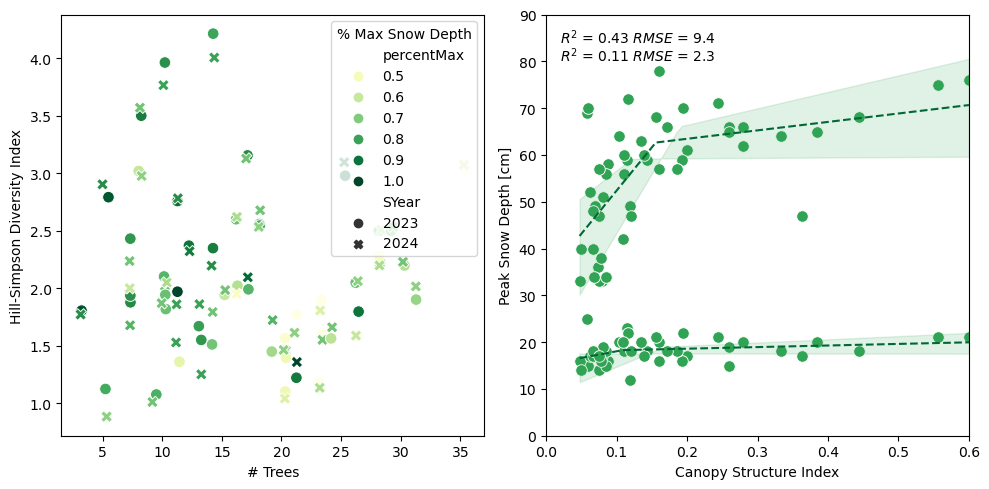

In [ ]:
#Cubic
#def func(x, a, b, c, d):
#    return a*(x**3) + b*(x**2) + c*x + d

#Log
#def func(x, a, b):
#    return a*np.log(x) + b

#Piecewise
def func(x, x0, y0, k1, k2):
    y = np.piecewise(x, [x < x0, x >= x0],
                     [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
    return y


#Linear regression
#def func(x, a, b):
#    return a*x + b


#Plot variability vs. magnitude
fig, [ax, ax1] = plt.subplots(1, 2, figsize = (10, 5), 
                              layout = 'tight')

#Scatterplot with snow above minimum recorded depth
max2023 = max(peakData[peakData.SYear == 2023].maxDepth)
max2024 = max(peakData[peakData.SYear == 2024].maxDepth)
peakData['percentMax'] = [((peakData.maxDepth[i]/max2023) if (peakData.SYear[i] == 2023) else (peakData.maxDepth[i]/max2024)) for i in peakData.index]
sns.scatterplot(x = jitter(peakData['nTrees'], 0.25), y = jitter(peakData['S'], 0.05), hue = peakData['percentMax'], 
            style = peakData.SYear,
            palette = 'YlGn', 
            s = 70, 
            ax = ax)

ax.legend(title = '% Max Snow Depth')
ax.set_xlabel('# Trees')
ax.set_ylabel('Hill-Simpson Diversity Index')

peakData['divIndex'] = peakData.S/(peakData.nTrees)
forFit = peakData.dropna(how='any')
x_fit2023 = forFit[forFit.SYear == 2023].divIndex.to_numpy()
y_fit2023 = forFit[forFit.SYear == 2023].maxDepth.to_numpy()
x_fit2024 = forFit[forFit.SYear == 2024].divIndex.to_numpy()
y_fit2024 = forFit[forFit.SYear == 2024].maxDepth.to_numpy()

##Fit 2023
p2023 = [0.12, 60, 600, 20] #initial optimization guesses
popt2023, pcov2023 = curve_fit(func, x_fit2023, y_fit2023, p0 = p2023)
#Rsquared calculation
residuals2023 = y_fit2023 - func(x_fit2023, *popt2023)
ss_res2023 = np.sum(residuals2023**2)
ss_tot2023 = np.sum((y_fit2023 - np.mean(y_fit2023))**2)
r_squared2023 = 1 - (ss_res2023 / ss_tot2023)
#RMSE calculation
RMSE2023 = sqrt(np.sum((residuals2023)**2)/(len(residuals2023)))

##Fit 2024
p2024 = [0.1, 18, 90, 10] #initial optimization guesses
popt2024, pcov2024 = curve_fit(func, x_fit2024, y_fit2024, p0 = p2024)
#Rsquared calculation
residuals2024 = y_fit2024 - func(x_fit2024, *popt2024)
ss_res2024 = np.sum(residuals2024**2)
ss_tot2024 = np.sum((y_fit2024 - np.mean(y_fit2024))**2)
r_squared2024 = 1 - (ss_res2024 / ss_tot2024)
#RMSE calculation
RMSE2024 = sqrt(np.sum((residuals2024)**2)/(len(residuals2024)))

#Scatterplot
sns.scatterplot(data = peakData, x = 'divIndex', y = 'maxDepth', color = pal[3], s = 70, ax = ax1)

#plot 2023
x2023 = np.sort(x_fit2023)
ax1.plot(x2023, func(x2023, *popt2023), linestyle = '--', color = pal[4])

#plot 2024
x2024 = np.sort(x_fit2024)
ax1.plot(x2024, func(x2024, *popt2024), linestyle = '--', color = pal[4])

#2023 Add 90% confidence interval
sigma_ab2023 = np.sqrt(np.diagonal(pcov2023))
bound_upper2023 = func(x2023, *(popt2023 + sigma_ab2023))
bound_lower2023 = func(x2023, *(popt2023 - sigma_ab2023))
plt.fill_between(x2023, bound_lower2023, bound_upper2023,
                 alpha = 0.15, 
                 color = pal[3])

#2024 Add 90% confidence interval
sigma_ab2024 = np.sqrt(np.diagonal(pcov2024))
bound_upper2024 = func(x2024, *(popt2024 + sigma_ab2024))
bound_lower2024 = func(x2024, *(popt2024 - sigma_ab2024))
plt.fill_between(x2024, bound_lower2024, bound_upper2024,
                 alpha = 0.15, 
                 color = pal[3])

ax1.text(0.02, 84, '$ R^2 $ = ' + str(round_sig(r_squared2023, 2)) + ' $ RMSE $ = ' + str(round_sig(RMSE2023, 2)))
ax1.text(0.02, 80, '$ R^2 $ = ' + str(round_sig(r_squared2024, 2)) + ' $ RMSE $ = ' + str(round_sig(RMSE2024, 2)))
ax1.set_xlabel('Canopy Structure Index')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlim(0, max(peakData.divIndex))
ax1.set_ylim(0, 90)

plt.savefig(paper_savepath + 'Diversity-analysis.pdf')


### Entropy

In [ ]:
#Information Entropy Approach
def entropy(counts):
  norm_counts = counts / counts.sum()
  base = e 
  norm_counts = norm_counts[norm_counts != 0]
  return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

In [ ]:
peakData['Entropy'] = [entropy(np.array([peakData.nCo[i], peakData.nDom[i], peakData.nInt[i], peakData.nSup[i]])) for i in peakData.index]
peakData.describe()

,northing,easting,aspect,slope,SYear,maxDepth,lai5ring,avgDist_m,avgDBH_cm,sdDist_m,...,basalArea_m2,nCo,nDom,nInt,nSup,pCon,S,percentMax,divIndex,Entropy
count,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.00000,100.000000,100.00000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,464585.436000,5.262586e+06,178.620753,4.721854,2023.500000,37.130000,1.039160,5.111763,19.023672,1.897849,...,5.269255,10.72000,1.360000,3.42000,1.22000,0.514541,2.042451,0.722272,0.165387,0.776583
std,126.911347,2.898770e+02,100.540202,5.888669,0.502519,21.131457,0.657986,0.529204,4.260330,0.374086,...,2.774648,6.03371,1.473812,3.18513,2.13948,0.374687,0.685950,0.132987,0.125989,0.335990
min,464335.000000,5.262240e+06,0.008743,0.253367,2023.000000,12.000000,0.008631,4.038600,12.014286,0.865600,...,0.830668,0.00000,0.000000,0.00000,0.00000,0.000000,1.000000,0.423077,0.047423,-0.000000
25%,464520.400000,5.262396e+06,100.015000,0.786230,2023.000000,18.000000,0.403804,4.820194,16.011111,1.719601,...,2.845013,7.00000,0.000000,1.00000,0.00000,0.142857,1.555556,0.640000,0.075410,0.617242
50%,464582.200000,5.262500e+06,188.117800,2.383635,2023.500000,29.000000,1.074828,5.064195,17.887888,1.857442,...,4.945247,9.50000,1.000000,2.00000,0.00000,0.579576,1.916762,0.720000,0.117841,0.800897
75%,464670.600000,5.262658e+06,254.406600,6.632267,2024.000000,58.250000,1.656040,5.468983,22.065000,2.100286,...,7.761783,17.00000,2.000000,5.00000,1.00000,0.913043,2.465409,0.810897,0.193548,1.028514
max,464819.000000,5.263285e+06,355.678900,25.447800,2024.000000,78.000000,2.677331,6.334163,31.160000,2.728054,...,10.131848,22.00000,5.000000,13.00000,10.00000,1.000000,3.920000,1.000000,0.600000,1.376055


(0.0, 4.0)

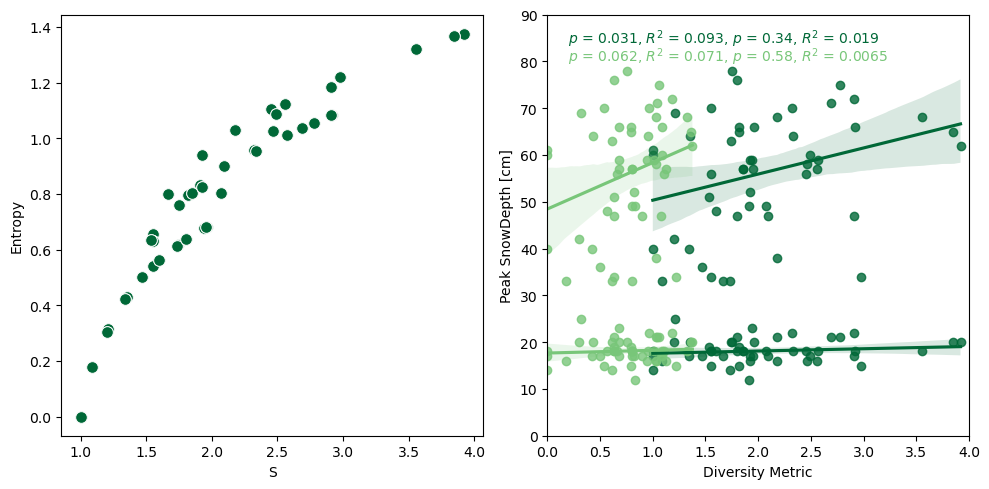

In [ ]:
#Entropy vs diversity index
#Plot variability vs. magnitude
fig, [ax, ax1] = plt.subplots(1, 2, figsize = (10, 5), 
                              layout = 'tight')


sns.scatterplot(data = peakData, x = 'S', y = 'Entropy', 
                s = 70,
                color = pal[4], 
                ax = ax)

SMod2023 = smf.ols('maxDepth ~ S', data = peakData[peakData.SYear == 2023]).fit()
SMod2024 = smf.ols('maxDepth ~ S', data = peakData[peakData.SYear == 2024]).fit()
EntropyMod2023 = smf.ols('maxDepth ~ Entropy', data = peakData[peakData.SYear == 2023]).fit()
EntropyMod2024 = smf.ols('maxDepth ~ Entropy', data = peakData[peakData.SYear == 2024]).fit()
sns.regplot(data = peakData[peakData.SYear == 2023], x = 'S', y = 'maxDepth', 
            color = pal[4],
            ax = ax1)
sns.regplot(data = peakData[peakData.SYear == 2024], x = 'S', y = 'maxDepth', 
            color = pal[4],
            ax = ax1)

sns.regplot(data = peakData[peakData.SYear == 2023], x = 'Entropy', y = 'maxDepth', 
            color = pal[2],
            ax = ax1)
sns.regplot(data = peakData[peakData.SYear == 2024], x = 'Entropy', y = 'maxDepth', 
            color = pal[2],
            ax = ax1)

ax1.set_xlabel('Diversity Metric')
ax1.set_ylabel('Peak SnowDepth [cm]')
ax1.text(0.2, 84, r'$ p $ = ' + str(round_sig(SMod2023.pvalues.S, 2)) + r', $ R^2 $ = ' + str(round_sig(SMod2023.rsquared, 2)) + r', $ p $ = ' + str(round_sig(SMod2024.pvalues.S, 2)) + r', $ R^2 $ = ' + str(round_sig(SMod2024.rsquared, 2)), 
         color = pal[4])
ax1.text(0.2, 80, r'$ p $ = ' + str(round_sig(EntropyMod2023.pvalues.Entropy, 2)) + r', $ R^2 $ = ' + str(round_sig(EntropyMod2023.rsquared, 2)) + r', $ p $ = ' + str(round_sig(EntropyMod2024.pvalues.Entropy, 2)) + r', $ R^2 $ = ' + str(round_sig(EntropyMod2024.rsquared, 2)), 
         color = pal[2])
ax1.set_ylim(0, 90)
ax1.set_xlim(0, 4)


### Repeat Cover Diagram

In [ ]:
def plotPieceWise(data, ax, color, xlab, ylab, p):
    #Preprocessing
    x_fit = data[data.divIndex > 0].divIndex.to_numpy()
    y_fit = data[data.divIndex > 0].maxDepth.to_numpy()

    #Fit function
    popt, pcov = curve_fit(func, x_fit, y_fit)#, p0 = p)

    #Rsquared calculation
    residuals = y_fit - func(x_fit, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
    r_squared = 1 - (ss_res / ss_tot)

    #RMSE calculation
    RMSE = sqrt(np.sum((residuals)**2)/(len(residuals)))

    #Plot Data
    #Scatterplot
    sns.scatterplot(data = data, x = 'divIndex', y = 'maxDepth', color = color, s = 70, ax = ax)

    #Plot line
    x_plot = np.sort(x_fit)
    ax.plot(x_plot, func(x_plot, *popt), linestyle = '--', color = color)

    #Add 90% confidence interval
    sigma_ab = np.sqrt(np.diagonal(pcov))
    bound_upper = func(x_plot, *(popt + sigma_ab))
    bound_lower = func(x_plot, *(popt - sigma_ab))
    ax.fill_between(x_plot, bound_lower, bound_upper,
                    alpha = 0.15, 
                    color = color)
    
    #add text
    ax.text(xlab, ylab, '$ R^2 $ = ' + str(round_sig(r_squared, 2)) + ' $ RMSE $ = ' + str(round_sig(RMSE, 2)))

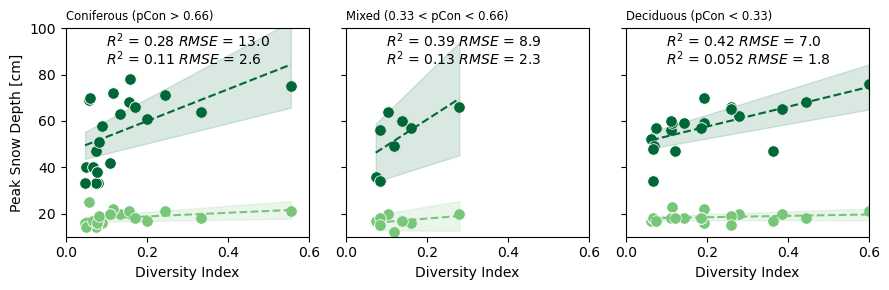

In [ ]:
#Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')




#Dense Coniferous
plotPieceWise(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2023)], ax1, pal[4], 0.1, 92, [0.12, 60, 600, 20])
plotPieceWise(peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2024)], ax1, pal[2], 0.1, 84, [0.1, 18, 90, 10])
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('Diversity Index')


#Mixed 
plotPieceWise(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2023)], ax2, pal[4], 0.1, 92, [0.12, 60, 600, 20])
plotPieceWise(peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2024)], ax2, pal[2], 0.1, 84, [0.1, 18, 90, 10])
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('Diversity Index')

#Dense Deciduous
plotPieceWise(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2023)], ax3, pal[4], 0.1, 92, [0.12, 60, 600, 20])
plotPieceWise(peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2024)], ax3, pal[2], 0.1, 84, [0.1, 18, 90, 10])
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('Diversity Index')

ax1.set_xlim(0, max(peakData.divIndex))
ax1.set_ylim(10, 100)

plt.savefig(paper_savepath + 'covertype_diversityregression.pdf', bbox_inches = 'tight')